In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/gauravsdeshmukh/ChemGCN
%cd ChemGCN

Cloning into 'ChemGCN'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 59 (delta 23), reused 37 (delta 11), pack-reused 0
Receiving objects: 100% (59/59), 48.05 KiB | 3.43 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/content/ChemGCN


In [ ]:
!python train_chemgcn.py

Epoch: [0]	Training Loss: [1.02]	Training MAE: [1.67]
Epoch: [1]	Training Loss: [1.01]	Training MAE: [1.66]
Epoch: [2]	Training Loss: [0.68]	Training MAE: [1.36]
Epoch: [3]	Training Loss: [0.40]	Training MAE: [1.06]
Epoch: [4]	Training Loss: [0.40]	Training MAE: [1.03]
Epoch: [5]	Training Loss: [0.34]	Training MAE: [0.97]
Epoch: [6]	Training Loss: [0.35]	Training MAE: [0.97]
Epoch: [7]	Training Loss: [0.30]	Training MAE: [0.91]
Epoch: [8]	Training Loss: [0.27]	Training MAE: [0.86]
Epoch: [9]	Training Loss: [0.28]	Training MAE: [0.86]
Epoch: [10]	Training Loss: [0.28]	Training MAE: [0.88]
Epoch: [11]	Training Loss: [0.28]	Training MAE: [0.86]
Epoch: [12]	Training Loss: [0.26]	Training MAE: [0.85]
Epoch: [13]	Training Loss: [0.29]	Training MAE: [0.88]
Epoch: [14]	Training Loss: [0.25]	Training MAE: [0.84]
Epoch: [15]	Training Loss: [0.27]	Training MAE: [0.86]
Epoch: [16]	Training Loss: [0.25]	Training MAE: [0.82]
Epoch: [17]	Training Loss: [0.23]	Training MAE: [0.78]



In [3]:
!pip install chemprop
!pip install rdkit-pypi  # should be included in above after Chemprop v1.6 release

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [4]:
!pip install rdkit-pypi
!pip install pandas
!pip install Pillow
!pip install matplotlib
!pip install pydot
!sudo apt-get -qq install graphviz

In [5]:
import torch
import torch.nn as nn

In [123]:
"""Data and graphs."""
import os

import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom as molDG
from rdkit.Chem import rdmolops
from torch.utils.data import Dataset


In [124]:
"""Train a ChemGCN model."""

import numpy as np
import torch

from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [125]:

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error


In [126]:
class Graph:
    def __init__(
        self, molecule_smiles: str,
        node_vec_len: int,
        max_atoms: int = None
      ):
        # Store properties
        self.smiles = molecule_smiles
        self.node_vec_len = node_vec_len
        self.max_atoms = max_atoms
        self.node_mat, self.adj_mat = self.smiles_to_graph()

        # Call helper function to convert SMILES to RDKit mol
        self.smiles_to_mol()

        # If valid mol is created, generate a graph of the mol
        if self.mol is not None:
            self.smiles_to_graph()

    def smiles_to_mol(self):
        # Use MolFromSmiles from RDKit to get molecule object
        mol = Chem.MolFromSmiles(self.smiles)

        # If a valid mol is not returned, set mol as None and exit
        if mol is None:
            self.mol = None
            return

        # Add hydrogens to molecule
        self.mol = Chem.AddHs(mol)

    def smiles_to_graph(self):
      mol = Chem.MolFromSmiles(self.smiles)
      if mol is None:
          raise ValueError(f"Invalid SMILES string: {(self.smiles)}")

      num_atoms = mol.GetNumAtoms()
      if num_atoms > self.max_atoms:
          num_atoms = self.max_atoms

      # print(f"Number of atoms: {num_atoms}")

      node_mat = np.zeros((self.max_atoms, self.node_vec_len))
      adj_mat = np.zeros((self.max_atoms, self.max_atoms))

      for atom_index, atom in enumerate(mol.GetAtoms()):
          if atom_index >= self.max_atoms:
              break
          atom_no = atom.GetAtomicNum()
          if atom_no < self.node_vec_len:
              node_mat[atom_index, atom_no] = 1

      for bond in mol.GetBonds():
          begin = bond.GetBeginAtomIdx()
          end = bond.GetEndAtomIdx()
          if begin < self.max_atoms and end < self.max_atoms:
              adj_mat[begin, end] = 1
              adj_mat[end, begin] = 1

      # print(f"Node matrix shape: {node_mat.shape}")
      # print(f"Adjacency matrix shape: {adj_mat.shape}")

      return node_mat, adj_mat


In [127]:
class GraphData(Dataset):
    def __init__(self, dataset_path: str, node_vec_len: int, max_atoms: int):
        # Save attributes
        self.node_vec_len = node_vec_len
        self.max_atoms = max_atoms

        # Open dataset file
        df = pd.read_csv(dataset_path)

        # Create lists
        self.indices = df.index.to_list()
        self.smiles = df["smiles"].to_list()
        self.outputs = df["logBB"].to_list()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i: int):
        # Get smile
        smile = self.smiles[i]

        # Create MolGraph object using the Graph abstraction
        mol = Graph(smile, self.node_vec_len, self.max_atoms)

        # Get node and adjacency matrices
        node_mat = torch.Tensor(mol.node_mat)
        adj_mat = torch.Tensor(mol.adj_mat)

        # Get output
        output = torch.Tensor([self.outputs[i]])

        return (node_mat, adj_mat), output, smile

In [128]:
def collate_graph_dataset(dataset: Dataset):
    # Create empty lists of node and adjacency matrices, outputs, and smiles
    node_mats = []
    adj_mats = []
    outputs = []
    smiles = []

    # Iterate over list and assign each component to the correct list
    for i in range(len(dataset)):
        (node_mat,adj_mat), output, smile = dataset[i]
        node_mats.append(node_mat)
        adj_mats.append(adj_mat)
        outputs.append(output)
        smiles.append(smile)


    # Create tensors
    node_mats_tensor = torch.cat(node_mats, dim=0)
    adj_mats_tensor = torch.cat(adj_mats, dim=0)
    outputs_tensor = torch.stack(outputs, dim=0)

    # Return tensors
    return (node_mats_tensor, adj_mats_tensor), outputs_tensor, smiles

In [129]:

class ConvolutionLayer(nn.Module):
    def __init__(self, node_in_len: int, node_out_len: int):
        # Call constructor of base class
        super().__init__()

        # Create linear layer for node matrix
        self.conv_linear = nn.Linear(node_in_len, node_out_len)

        # Create activation function
        self.conv_activation = nn.LeakyReLU()

    def forward(self, node_mat, adj_mat):
        # Calculate number of neighbors
        n_neighbors = adj_mat.sum(dim=-1, keepdims=True)
        # Create identity tensor
        self.idx_mat = torch.eye(
            adj_mat.shape[-2], adj_mat.shape[-1], device=n_neighbors.device
        )
        # Add new (batch) dimension and expand
        idx_mat = self.idx_mat.unsqueeze(0).expand(*adj_mat.shape)
        # Get inverse degree matrix
        inv_degree_mat = torch.mul(idx_mat, 1 / n_neighbors)

        # Perform matrix multiplication: D^(-1)AN
        node_fea = torch.bmm(inv_degree_mat, adj_mat)
        node_fea = torch.bmm(node_fea, node_mat)

        # Perform linear transformation to node features
        # (multiplication with W)
        node_fea = self.conv_linear(node_fea)

        # Apply activation
        node_fea = self.conv_activation(node_fea)

        return node_fea

In [130]:
class PoolingLayer(nn.Module):
    def __init__(self):
        # Call constructor of base class
        super().__init__()

    def forward(self, node_fea):
        # Pool the node matrix
        pooled_node_fea = node_fea.mean(dim=1)
        return pooled_node_fea

In [131]:

class ChemGCN(nn.Module):
    def __init__(
        self,
        node_vec_len: int,
        node_fea_len: int,
        hidden_fea_len: int,
        n_conv: int,
        n_hidden: int,
        n_outputs: int,
        p_dropout: float = 0.0,
    ):
        # Call constructor of base class
        super().__init__()

        # Define layers
        # Initial transformation from node matrix to node features
        self.init_transform = nn.Linear(node_vec_len, node_fea_len)

        # Convolution layers
        self.conv_layers = nn.ModuleList(
            [
                ConvolutionLayer(
                    node_in_len=node_fea_len,
                    node_out_len=node_fea_len,
                )
                for i in range(n_conv)
            ]
        )

        # Pool convolution outputs
        self.pooling = PoolingLayer()
        pooled_node_fea_len = node_fea_len

        # Pooling activation
        self.pooling_activation = nn.LeakyReLU()

        # From pooled vector to hidden layers
        self.pooled_to_hidden = nn.Linear(pooled_node_fea_len, hidden_fea_len)

        # Hidden layer
        self.hidden_layer = nn.Linear(hidden_fea_len, hidden_fea_len)

        # Hidden layer activation function
        self.hidden_activation = nn.LeakyReLU()

        # Hidden layer dropout
        self.dropout = nn.Dropout(p=p_dropout)

        # If hidden layers more than 1, add more hidden layers
        self.n_hidden = n_hidden
        if self.n_hidden > 1:
            self.hidden_layers = nn.ModuleList(
                [self.hidden_layer for _ in range(n_hidden - 1)]
            )
            self.hidden_activation_layers = nn.ModuleList(
                [self.hidden_activation for _ in range(n_hidden - 1)]
            )
            self.hidden_dropout_layers = nn.ModuleList(
                [self.dropout for _ in range(n_hidden - 1)]
            )

        # Final layer going to the output
        self.hidden_to_output = nn.Linear(hidden_fea_len, n_outputs)

    def forward(self, node_mat, adj_mat):
        # Perform initial transform on node_mat
        node_fea = self.init_transform(node_mat)

        # Perform convolutions
        for conv in self.conv_layers:
            node_fea = conv(node_fea, adj_mat)

        # Perform pooling
        pooled_node_fea = self.pooling(node_fea)
        pooled_node_fea = self.pooling_activation(pooled_node_fea)

        # First hidden layer
        hidden_node_fea = self.pooled_to_hidden(pooled_node_fea)
        hidden_node_fea = self.hidden_activation(hidden_node_fea)
        hidden_node_fea = self.dropout(hidden_node_fea)

        # Subsequent hidden layers
        if self.n_hidden > 1:
            for i in range(self.n_hidden - 1):
                hidden_node_fea = self.hidden_layers[i](hidden_node_fea)
                hidden_node_fea = self.hidden_activation_layers[i](hidden_node_fea)
                hidden_node_fea = self.hidden_dropout_layers[i](hidden_node_fea)

        # Output
        out = self.hidden_to_output(hidden_node_fea)

        return out


In [132]:
class Standardizer:
    def __init__(self, X):
        self.mean = torch.mean(X)
        self.std = torch.std(X)

    def standardize(self, X):
        Z = (X - self.mean) / (self.std)
        return Z

    def restore(self, Z):
        X = self.mean + Z * self.std
        return X

    def state(self):
        return {"mean": self.mean, "std": self.std}

    def load(self, state):
        self.mean = state["mean"]
        self.std = state["std"]

In [133]:
import torch
from sklearn.metrics import mean_absolute_error

def train_model(
    epoch,
    model,
    training_dataloader,
    optimizer,
    loss_fn,
    standardizer,
    use_GPU,
    max_atoms,
    node_vec_len,
):
    avg_loss = 0
    avg_mae = 0
    count = 0

    model.train()

    device = torch.device("cuda" if use_GPU and torch.cuda.is_available() else "cpu")

    for i, dataset in enumerate(training_dataloader):
        node_mat = dataset[0][0].to(device)
        adj_mat = dataset[0][1].to(device)
        output = dataset[1].to(device)

        check_for_nan(node_mat, 'node_mat')
        check_for_nan(adj_mat, 'adj_mat')
        check_for_nan(output, 'output')

        first_dim = int((torch.numel(node_mat)) / (max_atoms * node_vec_len))
        node_mat = node_mat.reshape(first_dim, max_atoms, node_vec_len)
        adj_mat = adj_mat.reshape(first_dim, max_atoms, max_atoms)

        output_std = standardizer.standardize(output)

        nn_input = (node_mat, adj_mat)
        nn_output = output_std

        nn_prediction = model(*nn_input)

        check_for_nan(nn_prediction, 'nn_prediction')

        loss = loss_fn(nn_output, nn_prediction)
        avg_loss += loss.item()

        prediction = standardizer.restore(nn_prediction.detach().cpu())
        mae = mean_absolute_error(output.cpu(), prediction)
        avg_mae += mae

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += 1

    avg_loss /= count
    avg_mae /= count

    print(f"Epoch: [{epoch}]\tTraining Loss: [{avg_loss:.2f}]\tTraining MAE: [{avg_mae:.2f}]")

    return avg_loss, avg_mae


In [230]:
#### Fix seeds
np.random.seed(0)
torch.manual_seed(0)
use_GPU = torch.cuda.is_available()

#### Inputs
node_vec_len = 32
train_size = 0.7
batch_size = 64
hidden_nodes = 80
n_conv_layers = 5
n_hidden_layers = 2
learning_rate = 0.005
n_epochs = 100

#### Start by creating dataset

data_path = "/content/drive/MyDrive/BBB dataset/df.csv"


In [207]:
from rdkit import Chem

def get_max_atoms(smiles_list):
    max_atoms = 0
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            num_atoms = mol.GetNumAtoms()
            if num_atoms > max_atoms:
                max_atoms = num_atoms
    return max_atoms

# Load the dataset
df = pd.read_csv(data_path)
smiles_list = df["smiles"].to_list()

# Determine max_atoms
max_atoms = get_max_atoms(smiles_list)
max_atoms

127

In [208]:
dataset = GraphData(dataset_path=data_path, max_atoms=max_atoms,
                        node_vec_len=node_vec_len)

In [209]:
dataset

In [210]:
#### Split data into training and test sets
# Get train and test sizes
dataset_indices = np.arange(0, len(dataset), 1)
train_size = int(np.round(train_size * len(dataset)))
test_size = len(dataset) - train_size
print(train_size,test_size)
print(dataset_indices)

733 314
[   0    1    2 ... 1044 1045 1046]


In [211]:
train_size=733
test_size=314

In [212]:

# Randomly sample train and test indices
train_indices = np.random.choice(dataset_indices, size=train_size,
                                                            replace=False)
test_indices = np.array(list(set(dataset_indices) - set(train_indices)))


In [213]:
# Create dataoaders
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(dataset, batch_size=batch_size,
                          sampler=train_sampler,
                          collate_fn=collate_graph_dataset)
test_loader = DataLoader(dataset, batch_size=batch_size,
                         sampler=test_sampler,
                         collate_fn=collate_graph_dataset)

In [231]:
#### Initialize model, standardizer, optimizer, and loss function
# Model
model = ChemGCN(node_vec_len=node_vec_len, node_fea_len=hidden_nodes,
                hidden_fea_len=hidden_nodes, n_conv=n_conv_layers,
                n_hidden=n_hidden_layers, n_outputs=1, p_dropout=0.1)

In [232]:
import torch
import torch.nn as nn

# Collect outputs from training data to fit standardizer
outputs = []
for i in range(len(train_loader.dataset)):
    (_, output, _) = train_loader.dataset[i]
    outputs.append(output)
outputs = torch.stack(outputs).squeeze()

# Initialize standardizer with training outputs
standardizer = Standardizer(outputs)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize loss function
loss_fn = nn.MSELoss()


In [147]:
import torch
import torch.nn as nn

class ConvolutionLayer(nn.Module):
    def __init__(self, node_in_len: int, node_out_len: int):
        super().__init__()
        self.conv_linear = nn.Linear(node_in_len, node_out_len)
        self.conv_activation = nn.LeakyReLU()
        self.epsilon = 1e-8  # Small constant to avoid division by zero

    def forward(self, node_mat, adj_mat):
        n_neighbors = adj_mat.sum(dim=-1, keepdims=True)
        idx_mat = torch.eye(adj_mat.shape[-2], adj_mat.shape[-1], device=n_neighbors.device)
        inv_degree_mat = torch.mul(idx_mat, 1 / (n_neighbors + self.epsilon))

        node_fea = torch.bmm(inv_degree_mat, adj_mat)
        node_fea = torch.bmm(node_fea, node_mat)

        node_fea = self.conv_linear(node_fea)
        node_fea = self.conv_activation(node_fea)

        return node_fea

class PoolingLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, node_fea):
        pooled_node_fea = node_fea.mean(dim=1)
        return pooled_node_fea

class ChemGCN(nn.Module):
    def __init__(self, node_vec_len: int, node_fea_len: int, hidden_fea_len: int, n_conv: int, n_hidden: int, n_outputs: int, p_dropout: float = 0.0):
        super().__init__()
        self.init_transform = nn.Linear(node_vec_len, node_fea_len)
        self.conv_layers = nn.ModuleList([ConvolutionLayer(node_in_len=node_fea_len, node_out_len=node_fea_len) for _ in range(n_conv)])
        self.pooling = PoolingLayer()
        self.pooling_activation = nn.LeakyReLU()
        self.pooled_to_hidden = nn.Linear(node_fea_len, hidden_fea_len)
        self.hidden_layer = nn.Linear(hidden_fea_len, hidden_fea_len)
        self.hidden_activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=p_dropout)
        self.n_hidden = n_hidden

        if self.n_hidden > 1:
            self.hidden_layers = nn.ModuleList([self.hidden_layer for _ in range(n_hidden - 1)])
            self.hidden_activation_layers = nn.ModuleList([self.hidden_activation for _ in range(n_hidden - 1)])
            self.hidden_dropout_layers = nn.ModuleList([self.dropout for _ in range(n_hidden - 1)])

        self.hidden_to_output = nn.Linear(hidden_fea_len, n_outputs)

    def forward(self, node_mat, adj_mat):
        node_fea = self.init_transform(node_mat)

        for conv in self.conv_layers:
            node_fea = conv(node_fea, adj_mat)

        pooled_node_fea = self.pooling(node_fea)
        pooled_node_fea = self.pooling_activation(pooled_node_fea)

        hidden_node_fea = self.pooled_to_hidden(pooled_node_fea)
        hidden_node_fea = self.hidden_activation(hidden_node_fea)
        hidden_node_fea = self.dropout(hidden_node_fea)

        if self.n_hidden > 1:
            for i in range(self.n_hidden - 1):
                hidden_node_fea = self.hidden_layers[i](hidden_node_fea)
                hidden_node_fea = self.hidden_activation_layers[i](hidden_node_fea)
                hidden_node_fea = self.hidden_dropout_layers[i](hidden_node_fea)

        out = self.hidden_to_output(hidden_node_fea)

        # Check if there are NaNs in the output
        if torch.isnan(out).any():
            print(f"NaN detected in output tensor!")

        return out


In [233]:
#### Train the model
loss = []
mae = []
epoch = []
for i in range(n_epochs):
    epoch_loss, epoch_mae = train_model(
        i,
        model,
        train_loader,
        optimizer,
        loss_fn,
        standardizer,
        use_GPU,
        max_atoms,
        node_vec_len,
    )
    loss.append(epoch_loss)
    mae.append(epoch_mae)
    epoch.append(i)

Epoch: [0]	Training Loss: [0.96]	Training MAE: [0.56]
Epoch: [1]	Training Loss: [0.95]	Training MAE: [0.55]
Epoch: [2]	Training Loss: [0.94]	Training MAE: [0.55]
Epoch: [3]	Training Loss: [0.87]	Training MAE: [0.53]
Epoch: [4]	Training Loss: [0.83]	Training MAE: [0.51]
Epoch: [5]	Training Loss: [0.85]	Training MAE: [0.53]
Epoch: [6]	Training Loss: [0.79]	Training MAE: [0.50]
Epoch: [7]	Training Loss: [0.81]	Training MAE: [0.50]
Epoch: [8]	Training Loss: [0.83]	Training MAE: [0.52]
Epoch: [9]	Training Loss: [0.80]	Training MAE: [0.50]
Epoch: [10]	Training Loss: [0.80]	Training MAE: [0.51]
Epoch: [11]	Training Loss: [0.76]	Training MAE: [0.49]
Epoch: [12]	Training Loss: [0.80]	Training MAE: [0.50]
Epoch: [13]	Training Loss: [0.74]	Training MAE: [0.48]
Epoch: [14]	Training Loss: [0.74]	Training MAE: [0.48]
Epoch: [15]	Training Loss: [0.75]	Training MAE: [0.48]
Epoch: [16]	Training Loss: [0.77]	Training MAE: [0.49]
Epoch: [17]	Training Loss: [0.73]	Training MAE: [0.48]
Epoch: [18]	Training

In [203]:
def test_model(
    model,
    test_dataloader,
    loss_fn,
    standardizer,
    use_GPU,
    max_atoms,
    node_vec_len,
):
    """
    Test the ChemGCN model.

    Parameters
    ----------
    model : ChemGCN
        ChemGCN model object
    test_dataloader : data.DataLoader
        Test DataLoader
    loss_fn : like nn.MSELoss()
        Model loss function
    standardizer : Standardizer
        Standardizer object
    use_GPU: bool
        Whether to use GPU
    max_atoms: int
        Maximum number of atoms in graph
    node_vec_len: int
        Maximum node vector length in graph

    Returns
    -------
    test_loss : float
        Test loss
    test_mae : float
        Test MAE
    """

    # Create variables to store losses and error
    test_loss = 0
    test_mae = 0
    count = 0

    # Switch model to train mode
    model.eval()

    # Go over each batch in the dataloader
    for i, dataset in enumerate(test_dataloader):
        # Unpack data
        node_mat = dataset[0][0]
        adj_mat = dataset[0][1]
        output = dataset[1]

        # Reshape inputs
        first_dim = int((torch.numel(node_mat)) / (max_atoms * node_vec_len))
        node_mat = node_mat.reshape(first_dim, max_atoms, node_vec_len)
        adj_mat = adj_mat.reshape(first_dim, max_atoms, max_atoms)

        # Standardize output
        output_std = standardizer.standardize(output)

        # Package inputs and outputs; check if GPU is enabled
        if use_GPU:
            nn_input = (node_mat.cuda(), adj_mat.cuda())
            nn_output = output_std.cuda()
        else:
            nn_input = (node_mat, adj_mat)
            nn_output = output_std

        # Compute output from network
        nn_prediction = model(*nn_input)

        # Calculate loss
        loss = loss_fn(nn_output, nn_prediction)
        test_loss += loss

        # Calculate MAE
        prediction = standardizer.restore(nn_prediction.detach().cpu())
        mae = mean_absolute_error(output, prediction)
        test_mae += mae

        # Increase count
        count += 1

    # Calculate avg loss and MAE
    test_loss = test_loss.detach().cpu().numpy() / count
    test_mae = test_mae / count

    # Return loss and MAE
    return test_loss, test_mae


def parity_plot(
    save_dir,
    model,
    test_dataloader,
    standardizer,
    use_GPU,
    max_atoms,
    node_vec_len,
):
    """
    Create a parity plot for the ChemGCN model.

    Parameters
    ----------
    save_dir: str
        Name of directory to store the parity plot in
    model : ChemGCN
        ChemGCN model object
    test_dataloader : data.DataLoader
        Test DataLoader
    standardizer : Standardizer
        Standardizer object
    use_GPU: bool
        Whether to use GPU
    max_atoms: int
        Maximum number of atoms in graph
    node_vec_len: int
        Maximum node vector length in graph

    """

    # Create variables to store losses and error
    outputs = []
    predictions = []

    # Switch model to train mode
    model.eval()

    # Go over each batch in the dataloader
    for i, dataset in enumerate(test_dataloader):
        # Unpack data
        node_mat = dataset[0][0]
        adj_mat = dataset[0][1]
        output = dataset[1]

        # Reshape inputs
        first_dim = int((torch.numel(node_mat)) / (max_atoms * node_vec_len))
        node_mat = node_mat.reshape(first_dim, max_atoms, node_vec_len)
        adj_mat = adj_mat.reshape(first_dim, max_atoms, max_atoms)

        # Package inputs and outputs; check if GPU is enabled
        if use_GPU:
            nn_input = (node_mat.cuda(), adj_mat.cuda())
        else:
            nn_input = (node_mat, adj_mat)

        # Compute output from network
        nn_prediction = model(*nn_input)

        # Calculate MAE
        prediction = standardizer.restore(nn_prediction.detach().cpu())

        # Add to list
        outputs.append(output)
        predictions.append(prediction)

    # Flatten
    outputs_arr = np.concatenate(outputs)
    preds_arr = np.concatenate(predictions)

    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=500)
    ax.scatter(
        outputs_arr, preds_arr, marker="o", color="mediumseagreen", edgecolor="black"
    )

    min_plot = min(ax.get_xlim()[0], ax.get_ylim()[0])
    max_plot = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_plot = (1 - np.sign(min_plot) * 0.2) * min_plot
    max_plot = (1 + np.sign(max_plot) * 0.2) * max_plot

    ax.plot([min_plot, max_plot], [min_plot, max_plot], linestyle="-", color="black")
    ax.margins(x=0, y=0)
    ax.set_xlim([min_plot, max_plot])
    ax.set_ylim([min_plot, max_plot])
    ax.set_xlabel("Measured values (log mols/l)")
    ax.set_ylabel("ChemGCN predictions (log mols/l)")
    ax.set_title("Parity plot")
    fig.tight_layout()


def loss_curve(save_dir, epochs, losses):
    """
    Make a loss curve.

    Parameters
    ----------
    save_dir: str
        Name of directory to store plot in
    epochs: list
        List of epochs
    losses: list
        List of losses

    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=500)
    ax.plot(epochs, losses, marker="o", linestyle="--", color="royalblue")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Mean squared loss")
    ax.set_title("Loss curve")
    fig.tight_layout()

In [234]:
#### Test the model
# Call test model function
test_loss, test_mae = test_model(model, test_loader, loss_fn, standardizer,
                                 use_GPU, max_atoms, node_vec_len)

#### Print final results
print(f"Training Loss: {loss[-1]:.2f}")
print(f"Training MAE: {mae[-1]:.2f}")
print(f"Test Loss: {test_loss:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Training Loss: 0.65
Training MAE: 0.45
Test Loss: 0.66
Test MAE: 0.45


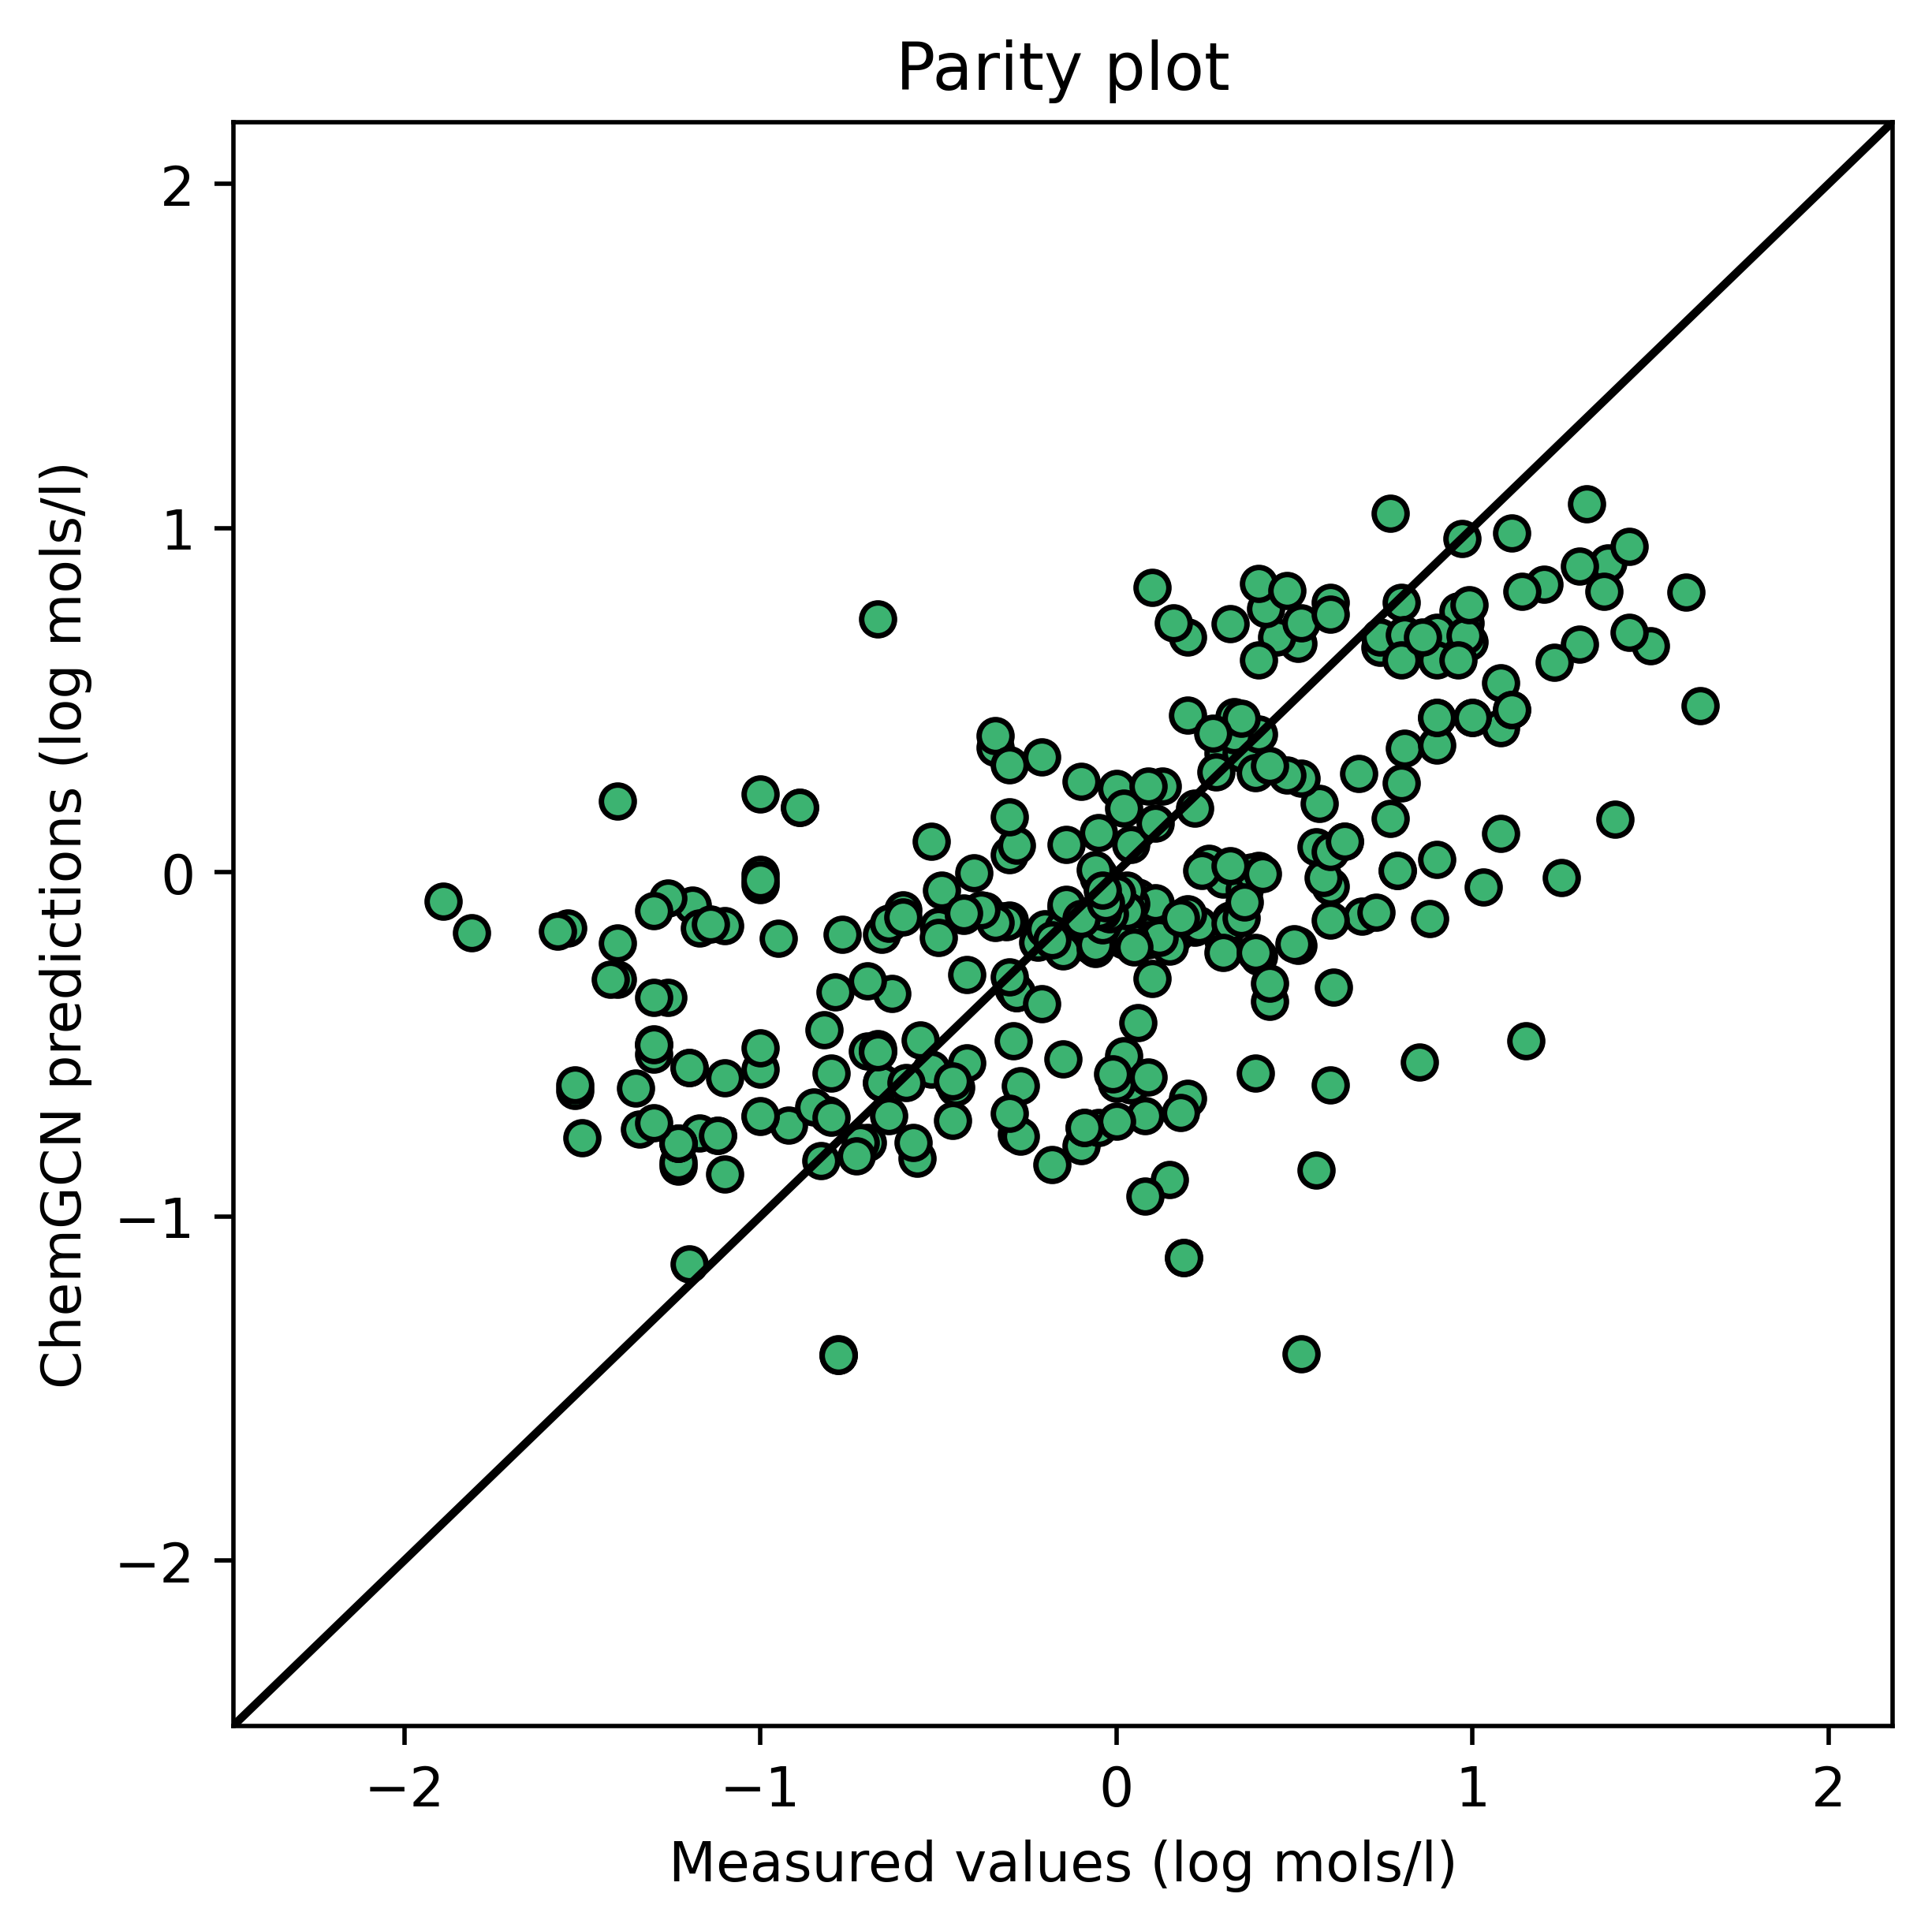

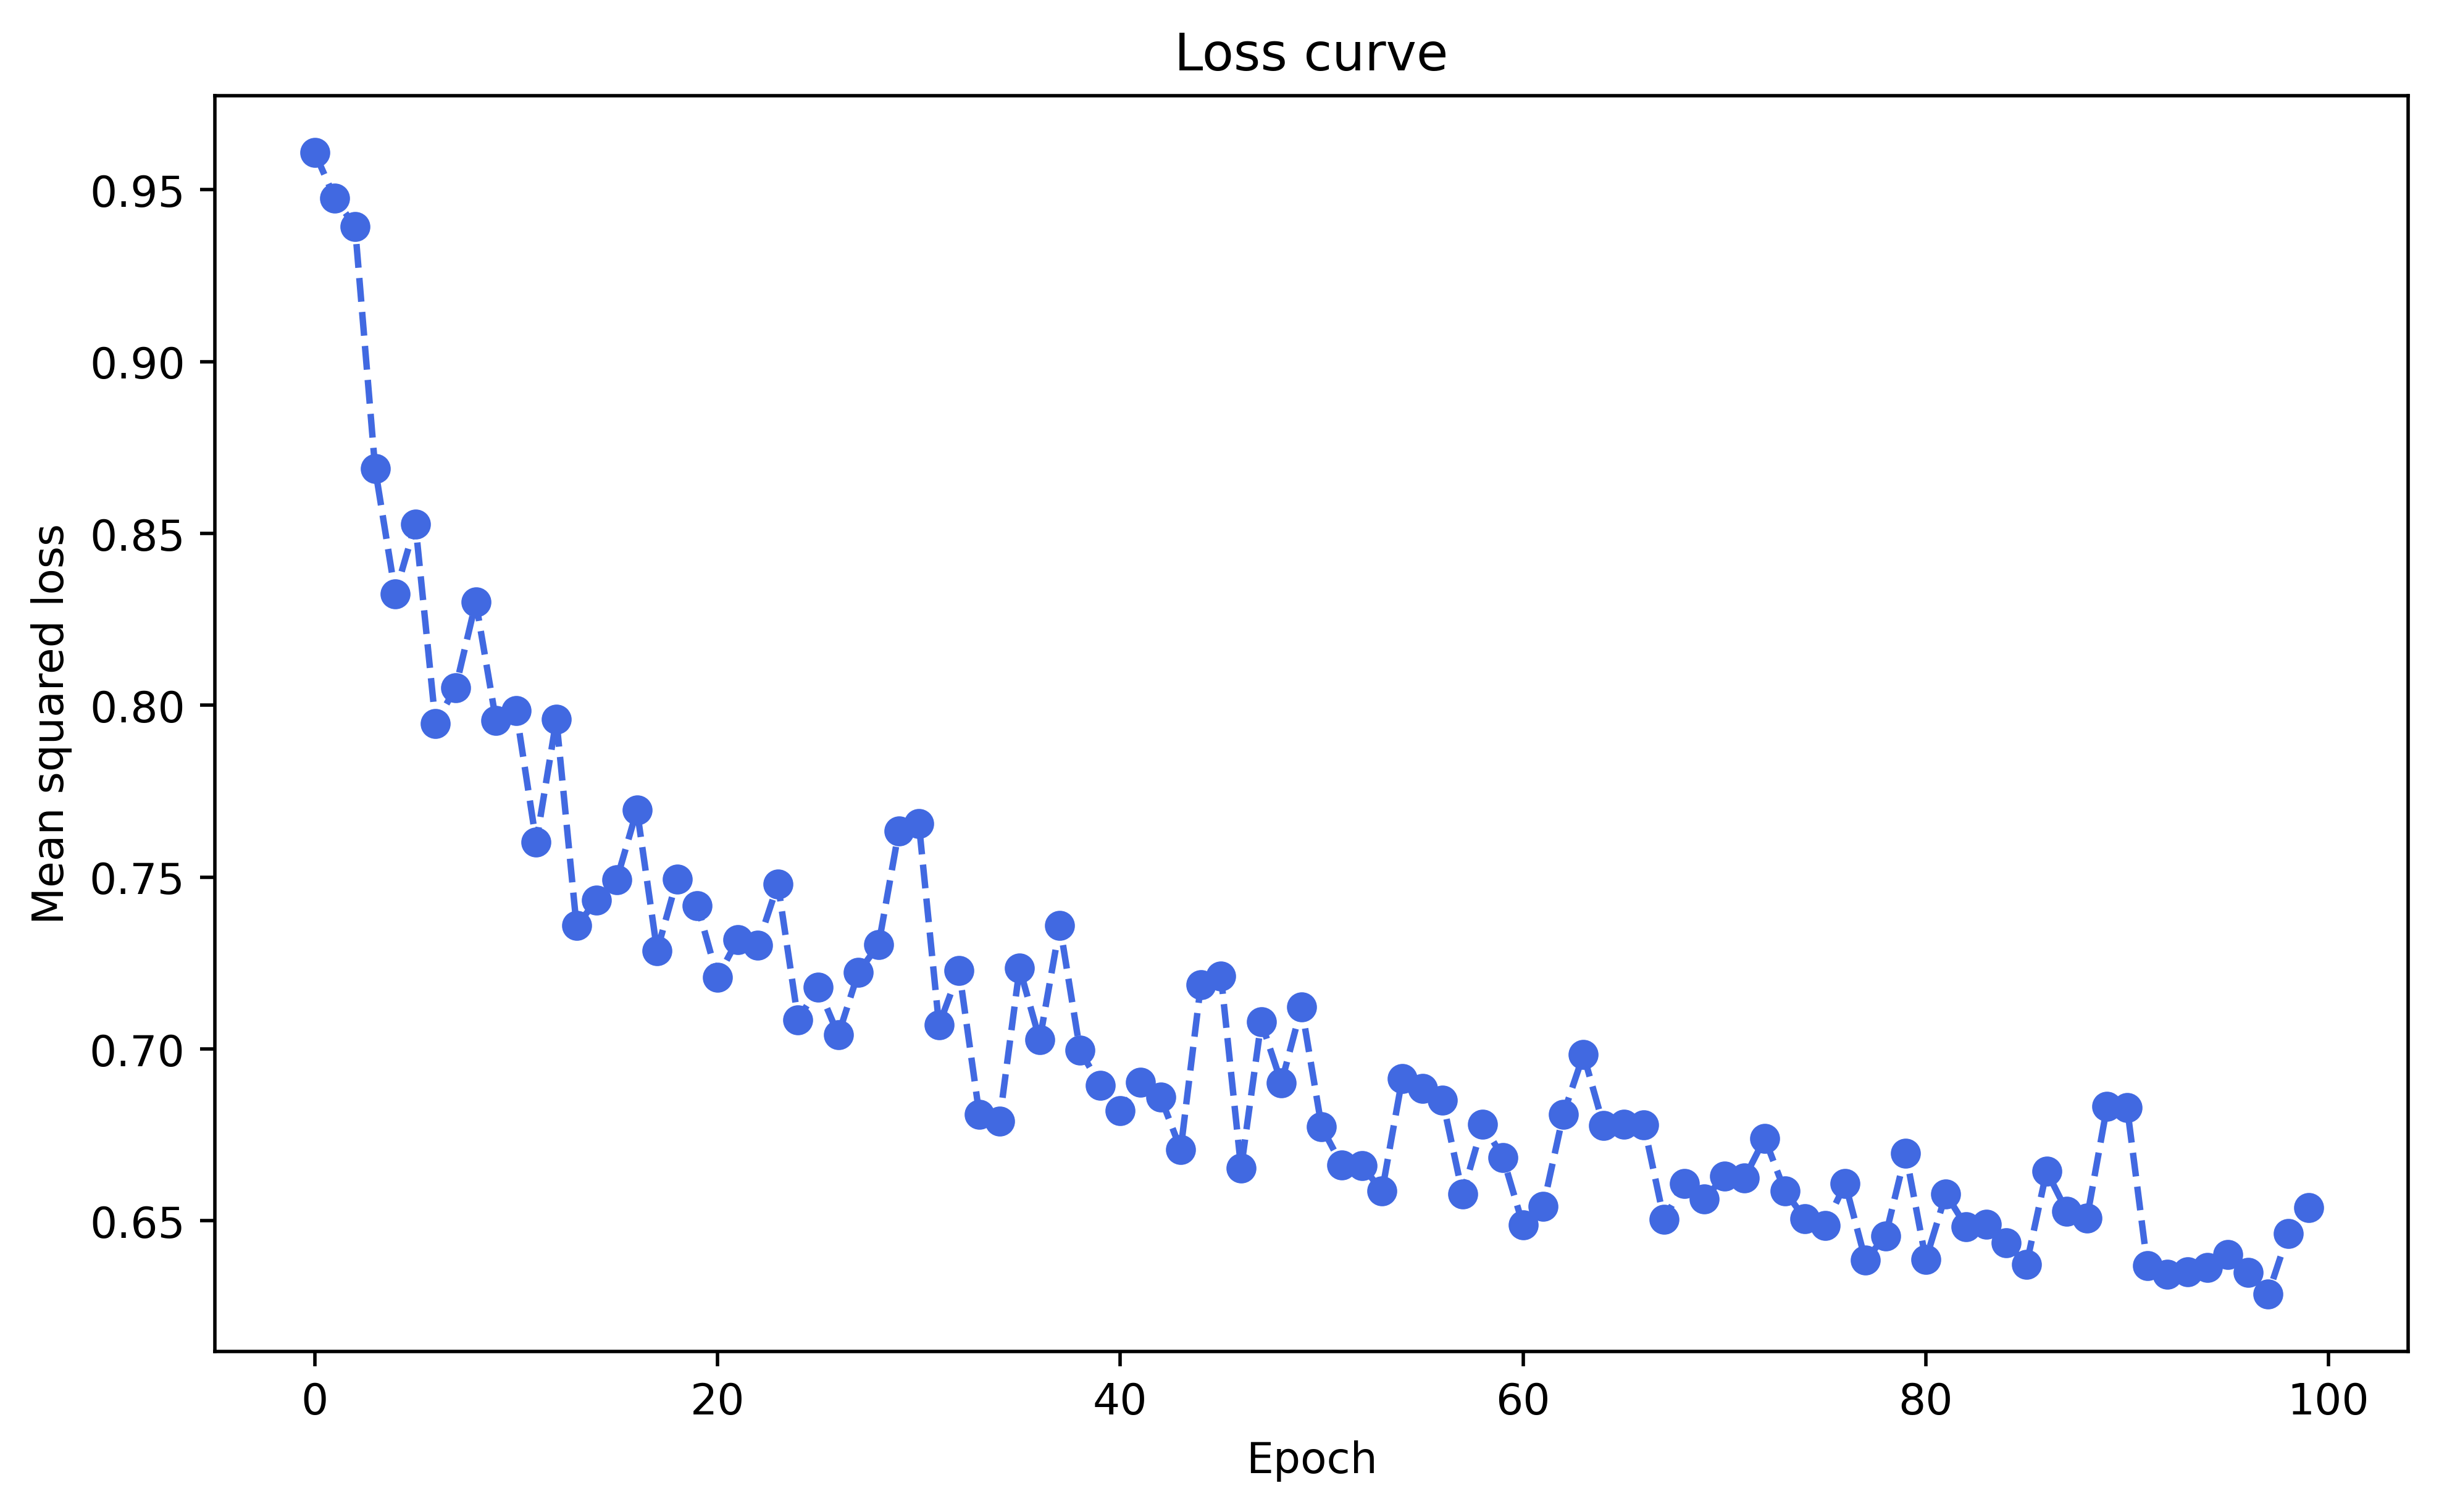

In [235]:
plot_dir = "/content/drive/MyDrive/BBB dataset/plots"
parity_plot(
    plot_dir, model, test_loader, standardizer, use_GPU, max_atoms, node_vec_len
)
loss_curve(plot_dir, epoch, loss)

In [238]:
# Installing Deepchem
!pip install --pre deepchem
import deepchem
deepchem.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.8.1.dev'

In [239]:
import deepchem as dc
# Installing conda
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install scikit-learn


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3457  100  3457    0     0  14137      0 --:--:-- --:--:-- --:--:-- 14168


add /root/miniconda/lib/python3.10/site-packages to PYTHONPATH
INFO:conda_installer:add /root/miniconda/lib/python3.10/site-packages to PYTHONPATH
python version: 3.10.12
INFO:conda_installer:python version: 3.10.12
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
INFO:conda_installer:fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
INFO:conda_installer:done
installing miniconda to /root/miniconda
INFO:conda_installer:installing miniconda to /root/miniconda
done
INFO:conda_installer:done
installing openmm, pdbfixer
INFO:conda_installer:installing openmm, pdbfixer
added conda-forge to channels
INFO:conda_installer:added conda-forge to channels
done
INFO:conda_installer:done
conda packages installation finished!
INFO:conda_installer:conda packages installation finished!


# conda environments:
#
base                     /root/miniconda



In [247]:
import pandas as pd
import deepchem as dc
from deepchem.models import GraphConvModel
from sklearn.model_selection import ParameterGrid

In [241]:
file_path = '/content/drive/MyDrive/BBB dataset/test_checkpoints_reg/fold_0/train_full.csv'
train = pd.read_csv(file_path)
train

,smiles,logBB
0,CC(C)(C)C1=CC2=NN=C(N2N=C1OCC3=NC=NN3C)C4=C(C=...,-0.20
1,CN(C)CC1=CC=C(O1)CSCCNC2=C(C(=CN2)CC3=CC=CC=C3...,-0.73
2,C=CCC1=C(C(=CC=C1)/C=N\NC(=O)CN2CCN(CC2)CC3=CC...,-1.67
3,C[NH2+]CCCN1C2=CC=CC=C2CCC3=CC=CC=C31,1.20
4,CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CN2CCN(CC2)CC(...,0.91
...,...,...
832,C1CCN(C1)CCN2C=CC3=C2C=C(C=C3)NC(=O)CC4=CC=C(C...,-0.59
833,CC1=C2C(=CC=C1)[C@@H]3CN(CC[C@@]3(C4=CC=CC=C4O...,0.82
834,CCC(C)N(C)C(=O)C1=CC2=CC=CC=C2C(=N1)C3=CC=CC=C3Cl,0.48
835,CCC(=O)NC1CCC(CC1)CCN2CCN(CC2)C3=C(C(=CC=C3)Cl)Cl,0.90


In [242]:
file_path = '/content/drive/MyDrive/BBB dataset/test_checkpoints_reg/fold_0/test_full.csv'
test = pd.read_csv(file_path)
test

,smiles,logBB
0,[N-]=[N+]=O,0.03
1,C1=CC(=CC(=C1)C(F)(F)F)/C(=N/OCCCCC(=O)O)/C2=C...,-1.00
2,CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2CCOC2)O)S(=...,-0.56
3,C1[C@@H]([C@H]1N)C2=CC=C(C=C2)F,0.81
4,CCCCCC1(C(=O)NC(=O)NC1=O)CC,0.09
...,...,...
100,C(C(F)(F)F)(Cl)Br,0.30
101,C1C2=CN=C(N2C3=C(C=C(C=C3)Cl)C(=N1)C4=CC=CC=C4...,-0.10
102,c1(C(C)C)onc(c4ncn2c4CNC(c3c2cccc3Cl)=O)n1,-0.30
103,CN1CC2C(C1)C3=C(C=CC(=C3)Cl)OC4=CC=CC=C24,1.03


In [243]:
file_path = '/content/drive/MyDrive/BBB dataset/test_checkpoints_reg/fold_0/val_full.csv'
val = pd.read_csv(file_path)
val

,smiles,logBB
0,C1CCN(CC1)C2=NC(=NC3=C2N=C(N=C3N4CCCCC4)N(CCO)...,0.00
1,CN1CCC[C@H](C1)C2=NC3=CC=CC=C3N2CC4=CC=C(C=C4)F,0.43
2,CC[C@]1(C[C@@H](C2=C([C@H]1O)C(=C3C(=C2O)C(=O)...,0.56
3,CC1=CC=CC=C1C2=C(C=NC=C2)C(=O)N(C)CC3=CC(=CC(=...,0.68
4,CN=C(C[N+](=O)[O-])NCCCSC1=CC=C(O1)CN(C)C,-1.23
...,...,...
100,CC(CC1=CC=CC=C1)N,0.93
101,CN(C1CCN(CC1)CC(COC2=CC(=C(C=C2)F)F)O)C3=NC4=C...,0.59
102,CCC1(CC(C2=C(C1O)C(=C3C(=C2O)C(=O)C4=C(C3=O)C=...,0.56
103,CN(C)C1=[NH+]C=CC(=C1)C2=N[NH]C(=N2)N,-1.17


In [252]:
pip install --upgrade deepchem
pip install keras==2.13.0


SyntaxError: invalid syntax (<ipython-input-252-ea89986afbf1>, line 1)

In [253]:
from scipy import stats
from deepchem.metrics import pearson_r2_score

featurizer = dc.feat.ConvMolFeaturizer()

train_features = featurizer.featurize(train['smiles'].tolist())
val_features = featurizer.featurize(val['smiles'].tolist())
test_features = featurizer.featurize(test['smiles'].tolist())

# Create datasets
train_dataset = dc.data.NumpyDataset(X=train_features, y=train['logBB'].values)
val_dataset = dc.data.NumpyDataset(X=val_features, y=val['logBB'].values)
test_dataset = dc.data.NumpyDataset(X=test_features, y=test['logBB'].values)

# Normalize the datasets
transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)
train_dataset = transformer.transform(train_dataset)
val_dataset = transformer.transform(val_dataset)
test_dataset = transformer.transform(test_dataset)

# Define GCN model
gcn_model = GraphConvModel(n_tasks=1, mode='regression', batch_size=32, learning_rate=0.001)

# Train GCN model
gcn_model.fit(train_dataset, nb_epoch=30)

# Evaluate GCN model
gcn_train_scores = gcn_model.evaluate(train_dataset, metrics=[dc.metrics.Metric(pearson_r2_score)])
gcn_val_scores = gcn_model.evaluate(val_dataset, metrics=[dc.metrics.Metric(pearson_r2_score)])
gcn_test_scores = gcn_model.evaluate(test_dataset, metrics=[dc.metrics.Metric(pearson_r2_score)])

print("GCN Train Scores:", gcn_train_scores)
print("GCN Validation Scores:", gcn_val_scores)
print("GCN Test Scores:", gcn_test_scores)



ValueError: Unrecognized keyword arguments passed to BatchNormalization: {'fused': False}

In [249]:
from deepchem.models import GraphConvModel

def print_graphconv_model_architecture(model):
    """Print the architecture of the GraphConvModel."""

    # Print the type of model
    print(f"Model Type: {type(model)}")

    # Access and print the model's internal components
    if hasattr(model, 'model'):
        print("Model's internal Keras model:")
        print(model.model.summary())
    else:
        print("Model's internal Keras model is not available")



# Print the architecture
print_graphconv_model_architecture(gcn_model)


NameError: name 'gcn_model' is not defined

In [245]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Get predictions
train_preds = gcn_model.predict(train_dataset)
val_preds = gcn_model.predict(val_dataset)
test_preds = gcn_model.predict(test_dataset)

# Reverse the transformation for predictions and actual values
transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)
train_preds = transformer.untransform(train_preds)
val_preds = transformer.untransform(val_preds)
test_preds = transformer.untransform(test_preds)
train_y = transformer.untransform(train_dataset.y)
val_y = transformer.untransform(val_dataset.y)
test_y = transformer.untransform(test_dataset.y)

# Calculate MSE and RMSE
def calculate_metrics(true_values, predictions):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    return mse, rmse

train_mse, train_rmse = calculate_metrics(train_y, train_preds)
val_mse, val_rmse = calculate_metrics(val_y, val_preds)
test_mse, test_rmse = calculate_metrics(test_y, test_preds)

print(f"Training Set - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}")
print(f"Validation Set - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}")
print(f"Test Set - MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}")

NameError: name 'gcn_model' is not defined

In [246]:
import matplotlib.pyplot as plt

# Get predictions
train_preds = gcn_model.predict(train_dataset)
val_preds = gcn_model.predict(val_dataset)
test_preds = gcn_model.predict(test_dataset)

# Reverse the transformation for predictions and actual values
# Note: Ensure you have used the correct normalization transformer or similar for untransform
transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)
train_preds = transformer.untransform(train_preds)
val_preds = transformer.untransform(val_preds)
test_preds = transformer.untransform(test_preds)
train_y = transformer.untransform(train_dataset.y)
val_y = transformer.untransform(val_dataset.y)
test_y = transformer.untransform(test_dataset.y)

# Plotting training predictions vs actual values
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(train_y, train_preds, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Set: Actual vs Predicted Values')
plt.plot([min(train_y), max(train_y)], [min(train_y), max(train_y)], color='red')

# Plotting validation predictions vs actual values
plt.subplot(1, 3, 2)
plt.scatter(val_y, val_preds, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Validation Set: Actual vs Predicted Values')
plt.plot([min(val_y), max(val_y)], [min(val_y), max(val_y)], color='red')

# Plotting test predictions vs actual values
plt.subplot(1, 3, 3)
plt.scatter(test_y, test_preds, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Actual vs Predicted Values')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red')

plt.tight_layout()
plt.show()


NameError: name 'gcn_model' is not defined